In [1]:
# Cell: Fix for imbalanced-learn and sklearn version compatibility
!pip install --upgrade scikit-learn imbalanced-learn --quiet

In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/heart-attack-prediction-dataset/heart_attack_prediction_dataset.csv")

# Drop irrelevant or weakly correlated columns
columns_to_drop = [
    'Patient ID', 'Country', 'Continent', 'Hemisphere',
    'Income', 'Diet', 'Sleep Hours Per Day', 'Sedentary Hours Per Day',
    'Stress Level', 'Alcohol Consumption'  # optional: you can re-add later
]
df.drop(columns=columns_to_drop, inplace=True)

# Split 'Blood Pressure' into systolic and diastolic numeric columns
bp_split = df['Blood Pressure'].str.split('/', expand=True)
df['BP_Systolic'] = pd.to_numeric(bp_split[0], errors='coerce')
df['BP_Diastolic'] = pd.to_numeric(bp_split[1], errors='coerce')
df.drop(columns='Blood Pressure', inplace=True)

# Reorder columns to make things cleaner (optional)
cols = df.columns.tolist()
cols.insert(cols.index('Heart Attack Risk'), cols.pop(cols.index('BP_Systolic')))
cols.insert(cols.index('Heart Attack Risk'), cols.pop(cols.index('BP_Diastolic')))
df = df[cols]

# Show cleaned data
df.head()

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Exercise Hours Per Week,Previous Heart Problems,Medication Use,BMI,Triglycerides,Physical Activity Days Per Week,BP_Systolic,BP_Diastolic,Heart Attack Risk
0,67,Male,208,72,0,0,1,0,4.168189,0,0,31.251233,286,0,158,88,0
1,21,Male,389,98,1,1,1,1,1.813242,1,0,27.194973,235,1,165,93,0
2,21,Female,324,72,1,0,0,0,2.078353,1,1,28.176571,587,4,174,99,0
3,84,Male,383,73,1,1,1,0,9.828130,1,0,36.464704,378,3,163,100,0
4,66,Male,318,93,1,1,1,1,5.804299,1,0,21.809144,231,1,91,88,0


In [3]:
# Cell 2: Feature categorization and missing value handling

import numpy as np

# Separate target variable
target = 'Heart Attack Risk'

# Identify feature types
categorical = ['Sex']  #
binary = [
    'Diabetes', 'Family History', 'Smoking', 'Obesity',
    'Previous Heart Problems', 'Medication Use'
]
numerical = [col for col in df.columns if col not in categorical + binary + [target]]

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows with missing values (can be refined later if you want to impute instead)
df.dropna(inplace=True)

# Final shape check
print(f"\nFinal dataset shape after cleaning: {df.shape}")
print("\nData types summary:")
print(df.dtypes)

Missing values per column:
Age                                0
Sex                                0
Cholesterol                        0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Exercise Hours Per Week            0
Previous Heart Problems            0
Medication Use                     0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
BP_Systolic                        0
BP_Diastolic                       0
Heart Attack Risk                  0
dtype: int64

Final dataset shape after cleaning: (8763, 17)

Data types summary:
Age                                  int64
Sex                                 object
Cholesterol                          int64
Heart Rate                           int64
Diabetes                             int64
Family History                       int64
Smok

In [4]:
# Cell 3: Train-test split with stratification

from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=target)
y = df[target]

# Perform stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Show class distribution to verify stratification worked
print("Class distribution in full dataset:")
print(y.value_counts(normalize=True))

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Class distribution in full dataset:
Heart Attack Risk
0    0.641789
1    0.358211
Name: proportion, dtype: float64

Class distribution in training set:
Heart Attack Risk
0    0.641797
1    0.358203
Name: proportion, dtype: float64

Class distribution in test set:
Heart Attack Risk
0    0.641757
1    0.358243
Name: proportion, dtype: float64


In [5]:
# Cell 4: Preprocessing pipeline (categorical + numerical handling)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Categorical, binary, and numerical features
categorical = ['Sex']
binary = [
    'Diabetes', 'Family History', 'Smoking', 'Obesity',
    'Previous Heart Problems', 'Medication Use'
]
numerical = [
    'Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week',
    'BMI', 'Triglycerides', 'Physical Activity Days Per Week',
    'BP_Systolic', 'BP_Diastolic'
]

# Define preprocessing for categorical and numerical features
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
numerical_transformer = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical),
        ('num', numerical_transformer, numerical)
        # Binary features are left as-is
    ],
    remainder='passthrough'  # keeps binary columns as-is
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")

Processed training set shape: (7010, 16)
Processed test set shape: (1753, 16)


In [6]:
# Cell 5: Apply SMOTE to training data only

from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Print before and after class distribution
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))

Before SMOTE: Counter({0: 4499, 1: 2511})
After SMOTE: Counter({0: 4499, 1: 4499})


In [7]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Using the original X_train, y_train from cell 3

# Define numeric and categorical columns again for this cell (optional)
numeric_features = [
    'Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week',
    'BMI', 'Triglycerides', 'Physical Activity Days Per Week',
    'BP_Systolic', 'BP_Diastolic'
]
categorical_features = ['Sex']
binary_features = [
    'Diabetes', 'Family History', 'Smoking', 'Obesity',
    'Previous Heart Problems', 'Medication Use'
]

# Preprocessor: scale numeric, one-hot encode categorical, leave binary as-is
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'  # binary columns stay as is
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),

    # Polynomial features for interaction terms (degree=2, interaction only)
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),

    # Feature selection: Random Forest selects median-threshold important features
    ('feature_selection', SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'
    )),

    # Logistic Regression with L1 penalty and balanced class weights
    ('logreg', LogisticRegression(
        penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000, C=0.1, random_state=42
    ))
])

# Fit pipeline on training data (use original train split before SMOTE here)
pipeline.fit(X_train, y_train)

# Predict and evaluate on test data
from sklearn.metrics import classification_report, accuracy_score, f1_score

y_pred = pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5368
F1 Score: 0.4484
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.54      0.60      1125
           1       0.39      0.53      0.45       628

    accuracy                           0.54      1753
   macro avg       0.53      0.53      0.52      1753
weighted avg       0.57      0.54      0.55      1753



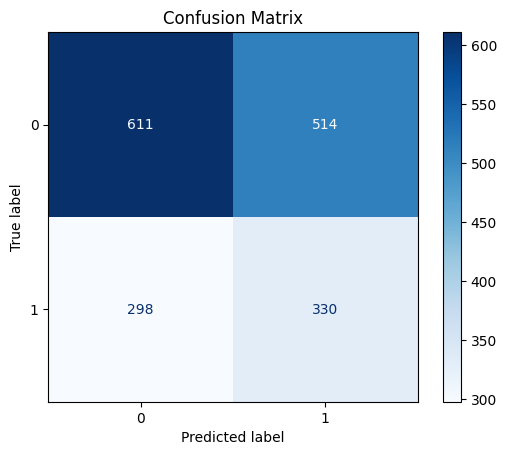

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test data
y_pred = pipeline.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()